In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols  # type: ignore
from statsmodels.stats.anova import anova_lm  # type: ignore
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
from embedding_utils import (
    load_embeddings,
    extract_llm_human_similarities_for_anova,
)

In [ ]:
# %%

all_embeddings = {
    "Base": load_embeddings("../data/embeddings.csv"),
    "Portuguese": load_embeddings("../data/embeddings_br.csv"),
    "German": load_embeddings("../data/embeddings_de.csv"),
    "Spanish": load_embeddings("../data/embeddings_es.csv"),
    "French": load_embeddings("../data/embeddings_fr.csv"),
}

language_codes = ["Base", "Portuguese", "German", "Spanish", "French"]

In [ ]:
# %%

df_anova = extract_llm_human_similarities_for_anova(all_embeddings, language_codes)
output_file = "../data/anova_data.csv"
df_anova.to_csv(output_file, index=False)

Processing languages: 100%|██████████| 5/5 [00:44<00:00,  8.91s/it]


In [ ]:
# %%

print("\n=== DESCRIPTIVE STATISTICS ===")
print("\nBy Actor (LLM + reasoning type):")
print(df_anova.groupby("actor1")["similarity"].describe())

print("\nBy Language:")
print(df_anova.groupby("language")["similarity"].describe())


=== DESCRIPTIVE STATISTICS ===

By Actor (LLM + reasoning type):
           count      mean       std       min       25%       50%       75%  \
actor1                                                                         
bison    32415.0  0.468649  0.171829 -0.122836  0.353794  0.482980  0.596709   
claude   35197.0  0.443925  0.149183 -0.093526  0.344205  0.457675  0.553226   
gemini    2782.0  0.420075  0.138107 -0.026329  0.316160  0.429498  0.520325   
gemma    56807.0  0.412248  0.147343 -0.123496  0.312786  0.420197  0.518765   
gpt3.5   35197.0  0.431743  0.152289 -0.157070  0.327977  0.441218  0.544673   
gpt4     24392.0  0.449702  0.161086 -0.112287  0.340394  0.461530  0.566736   
llama    35197.0  0.398568  0.169286 -0.193726  0.294331  0.418931  0.522492   
mistral  35197.0  0.390754  0.158668 -0.131123  0.283113  0.400599  0.506201   

              max  
actor1             
bison    0.925996  
claude   0.884231  
gemini   0.769867  
gemma    0.841023  
gpt3.5   0.87

In [ ]:
# %%

def plot_model_human_similarity(df_anova, language_codes):
    """
    Plot mean similarity between each model and humans across languages.
    Bars for the same model in different languages are grouped together.
    """
    summary = (
        df_anova.groupby(["actor1", "language"])["similarity"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    summary["stderr"] = summary["std"] / np.sqrt(summary["count"])

    actor_order = [
        "gpt3.5",
        "gpt4",
        "claude",
        "bison",
        "gemini",
        "llama",
        "mistral",
        "gemma",
    ]
    actors = [a for a in actor_order if a in summary["actor1"].unique()]

    model_name_map = {
        "gpt3.5": "GPT-3.5",
        "gpt4": "GPT-4",
        "claude": "Claude Haiku",
        "bison": "PaLM 2 Bison",
        "gemini": "Gemini 2",
        "llama": "Llama 2 7B",
        "mistral": "Mistral 7B",
        "gemma": "Gemma 7B",
    }

    language_display_names = {
        "Base": "English (Base)",
        "Portuguese": "Portuguese",
        "German": "German",
        "Spanish": "Spanish",
        "French": "French",
    }

    language_colors = {
        "Base": "#3274A1",
        "Portuguese": "#E1812C",
        "German": "#3A923A",
        "Spanish": "#C03D3E",
        "French": "#9372B2",
    }

    _, ax = plt.subplots(figsize=(14, 6))

    n_languages = len(language_codes)
    bar_width = 0.15
    group_gap = 0.3
    language_gap = 0.02

    x_positions = []
    current_x = 0

    for _, actor in enumerate(actors):
        actor_data = summary[summary["actor1"] == actor]

        for lang_idx, language in enumerate(language_codes):
            lang_data = actor_data[actor_data["language"] == language]

            if not lang_data.empty:
                mean_sim = lang_data["mean"].values[0]
                stderr = lang_data["stderr"].values[0]

                x_pos = current_x + lang_idx * (bar_width + language_gap)
                x_positions.append(x_pos)

                ax.bar(
                    x_pos,
                    mean_sim,
                    bar_width,
                    color=language_colors[language],
                    edgecolor="black",
                    linewidth=0.5,
                )

                ax.errorbar(
                    x_pos,
                    mean_sim,
                    yerr=stderr,
                    fmt="none",
                    ecolor="black",
                    capsize=3,
                    alpha=0.7,
                    linewidth=1,
                )

        current_x += n_languages * (bar_width + language_gap) + group_gap

    ax.set_ylabel("Mean Similarity to Humans", fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_title(
        "Model-Human Similarity Across Languages",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)

    tick_positions = []
    current_x = 0
    for actor in actors:
        center_x = (
            current_x
            + (n_languages * (bar_width + language_gap)) / 2
            - (bar_width + language_gap) / 2
        )
        tick_positions.append(center_x)
        current_x += n_languages * (bar_width + language_gap) + group_gap

    ax.set_xticks(tick_positions)
    ax.set_xticklabels([model_name_map.get(a, a.upper()) for a in actors], fontsize=10)

    legend_handles = [
        plt.Rectangle(
            (0, 0), 1, 1, fc=language_colors[lang], edgecolor="black", linewidth=0.5
        )
        for lang in language_codes
    ]
    ax.legend(
        legend_handles,
        [language_display_names[lang] for lang in language_codes],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=10,
        title="Language",
    )

    plt.tight_layout()
    plt.show()

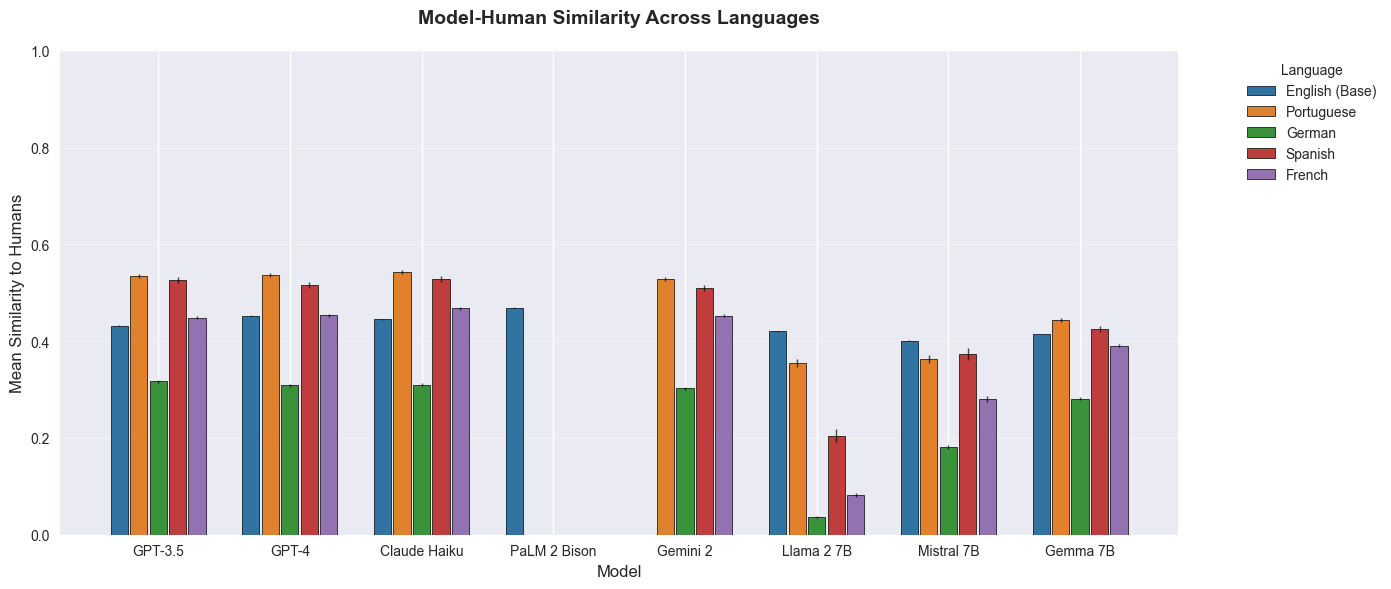

In [ ]:
# %%

plot_model_human_similarity(df_anova, language_codes)

In [ ]:
# %%

def plot_model_human_similarity_boxplot(df_anova, language_codes):
    """
    Plot box plots of similarity between each model and humans across languages.
    Box plots for the same model in different languages are grouped together.
    """
    actor_order = [
        "gpt3.5",
        "gpt4",
        "claude",
        "bison",
        "gemini",
        "llama",
        "mistral",
        "gemma",
    ]
    actors = [a for a in actor_order if a in df_anova["actor1"].unique()]

    model_name_map = {
        "gpt3.5": "GPT-3.5",
        "gpt4": "GPT-4",
        "claude": "Claude Haiku",
        "bison": "PaLM 2 Bison",
        "gemini": "Gemini 2",
        "llama": "Llama 2 7B",
        "mistral": "Mistral 7B",
        "gemma": "Gemma 7B",
    }

    language_display_names = {
        "Base": "English (Base)",
        "Portuguese": "Portuguese",
        "German": "German",
        "Spanish": "Spanish",
        "French": "French",
    }

    language_colors = {
        "Base": "#3274A1",
        "Portuguese": "#E1812C",
        "German": "#3A923A",
        "Spanish": "#C03D3E",
        "French": "#9372B2",
    }

    _, ax = plt.subplots(figsize=(14, 6))

    box_width = 0.15
    group_gap = 0.3
    language_gap = 0.02

    all_positions = []
    all_data = []
    all_colors = []

    current_x = 0

    for actor in actors:
        actor_data = df_anova[df_anova["actor1"] == actor]

        for lang_idx, language in enumerate(language_codes):
            lang_data = actor_data[actor_data["language"] == language]

            if not lang_data.empty:
                x_pos = current_x + lang_idx * (box_width + language_gap)
                all_positions.append(x_pos)
                all_data.append(lang_data["similarity"].values)
                all_colors.append(language_colors[language])

        current_x += len(language_codes) * (box_width + language_gap) + group_gap

    bp = ax.boxplot(
        all_data,
        positions=all_positions,
        widths=box_width,
        patch_artist=True,
        showfliers=True,
        flierprops=dict(marker="o", markersize=3, alpha=0.5),
        medianprops=dict(color="black", linewidth=1.5),
        boxprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1),
        capprops=dict(linewidth=1),
    )

    for patch, color in zip(bp["boxes"], all_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")
        patch.set_alpha(0.7)

    ax.set_ylabel("Similarity to Humans", fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_title(
        "Distribution of Model-Human Similarity Across Languages",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.set_ylim(-0.3, 1.0)
    ax.grid(axis="y", alpha=0.3)

    tick_positions = []
    current_x = 0
    for actor in actors:
        center_x = (
            current_x
            + (len(language_codes) * (box_width + language_gap)) / 2
            - (box_width + language_gap) / 2
        )
        tick_positions.append(center_x)
        current_x += len(language_codes) * (box_width + language_gap) + group_gap

    ax.set_xticks(tick_positions)
    ax.set_xticklabels([model_name_map.get(a, a.upper()) for a in actors], fontsize=10)

    legend_handles = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            fc=language_colors[lang],
            edgecolor="black",
            linewidth=0.5,
            alpha=0.7,
        )
        for lang in language_codes
    ]
    ax.legend(
        legend_handles,
        [language_display_names[lang] for lang in language_codes],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=10,
        title="Language",
    )

    plt.tight_layout()
    plt.show()

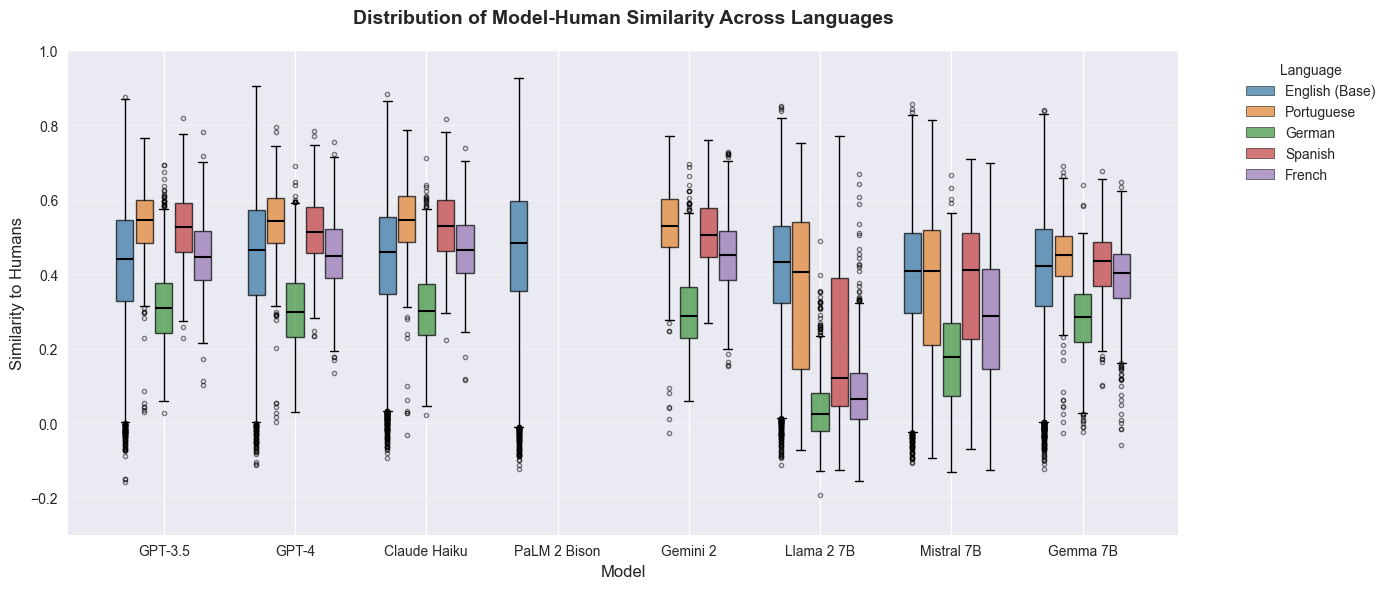

In [ ]:
# %%

plot_model_human_similarity_boxplot(df_anova, language_codes)

In [ ]:
# %%

print("\n=== POST-HOC TEST: Tukey's HSD ===")
tukey_results = pairwise_tukeyhsd(
    df_anova["similarity"],
    df_anova["actor1"] + "_" + df_anova["language"],
    alpha=0.005,
    use_var="unequal",
)

tukey_df = pd.DataFrame(
    tukey_results._results_table.data[1:],  # type: ignore[attr-defined]
    columns=tukey_results._results_table.data[0],  # type: ignore[attr-defined]
)
tukey_df[["model1", "language1"]] = tukey_df["group1"].str.split("_", n=1, expand=True)
tukey_df[["model2", "language2"]] = tukey_df["group2"].str.split("_", n=1, expand=True)
filtered_tukey = tukey_df[
    (tukey_df["model1"] == tukey_df["model2"])
    | (tukey_df["language1"] == tukey_df["language2"])
]

filtered_tukey_output_path = "../results/tukey_filtered.json"
filtered_tukey[
    ["group1", "group2", "meandiff", "p-adj", "lower", "upper", "reject"]
].to_json(filtered_tukey_output_path, orient="records", indent=2)

print(
    filtered_tukey[
        ["group1", "group2", "meandiff", "p-adj", "lower", "upper", "reject"]
    ].to_string(index=False)
)


=== POST-HOC TEST: Tukey's HSD ===
            group1             group2  meandiff  p-adj   lower   upper  reject
        bison_Base        claude_Base   -0.0237 0.0000 -0.0293 -0.0181    True
        bison_Base         gemma_Base   -0.0540 0.0000 -0.0591 -0.0489    True
        bison_Base        gpt3.5_Base   -0.0365 0.0000 -0.0422 -0.0309    True
        bison_Base          gpt4_Base   -0.0158 0.0000 -0.0223 -0.0093    True
        bison_Base         llama_Base   -0.0479 0.0000 -0.0535 -0.0424    True
        bison_Base       mistral_Base   -0.0676 0.0000 -0.0732 -0.0620    True
       claude_Base      claude_French    0.0226 0.0000  0.0078  0.0374    True
       claude_Base      claude_German   -0.1352 0.0000 -0.1502 -0.1202    True
       claude_Base  claude_Portuguese    0.0980 0.0000  0.0796  0.1163    True
       claude_Base     claude_Spanish    0.0827 0.0000  0.0541  0.1114    True
       claude_Base         gemma_Base   -0.0303 0.0000 -0.0349 -0.0257    True
       claude_Ba

In [ ]:
# %%

print("\n=== POST-HOC TEST: Games-Howell ===")
df_anova["group"] = df_anova["actor1"] + "_" + df_anova["language"]
gameshowell_results = pg.pairwise_gameshowell(
    data=df_anova,
    dv="similarity",
    between="group",
)

gameshowell_results[["model1", "language1"]] = gameshowell_results["A"].str.split(
    "_", n=1, expand=True
)
gameshowell_results[["model2", "language2"]] = gameshowell_results["B"].str.split(
    "_", n=1, expand=True
)
filtered_gameshowell = gameshowell_results[
    (gameshowell_results["model1"] == gameshowell_results["model2"])
    | (gameshowell_results["language1"] == gameshowell_results["language2"])
]

filtered_gameshowell_output_path = "../results/gameshowell_filtered.json"
filtered_gameshowell[
    ["A", "B", "mean(A)", "mean(B)", "diff", "se", "T", "df", "pval", "hedges"]
].to_json(filtered_gameshowell_output_path, orient="records", indent=2)

print(
    filtered_gameshowell[
        ["A", "B", "mean(A)", "mean(B)", "diff", "pval", "hedges"]
    ].to_string(index=False)
)

# # %%
# print("\n=== ONE-WAY ANOVA: Comparing Actors ===")
# actor_model = ols("similarity ~ C(actor1)", data=df_anova).fit()
# actor_anova_table = anova_lm(actor_model, typ=2)
# print(actor_anova_table)

# # %%
# print("\n=== ONE-WAY ANOVA: Comparing Languages ===")
# language_model = ols("similarity ~ C(language)", data=df_anova).fit()
# language_anova_table = anova_lm(language_model, typ=2)
# print(language_anova_table)


=== POST-HOC TEST: Games-Howell ===
                 A                  B  mean(A)  mean(B)      diff         pval    hedges
        bison_Base        claude_Base 0.468649 0.444935  0.023714 0.000000e+00  0.147104
        bison_Base         gemma_Base 0.468649 0.414653  0.053996 0.000000e+00  0.342711
        bison_Base        gpt3.5_Base 0.468649 0.432139  0.036509 0.000000e+00  0.223980
        bison_Base          gpt4_Base 0.468649 0.452852  0.015797 4.911405e-12  0.093730
        bison_Base         llama_Base 0.468649 0.420709  0.047940 0.000000e+00  0.299488
        bison_Base       mistral_Base 0.468649 0.401038  0.067611 3.994327e-11  0.417032
       claude_Base      claude_French 0.444935 0.467555 -0.022620 1.306770e-08 -0.152143
       claude_Base      claude_German 0.444935 0.309739  0.135196 9.436896e-15  0.909427
       claude_Base  claude_Portuguese 0.444935 0.542887 -0.097952 0.000000e+00 -0.657144
       claude_Base     claude_Spanish 0.444935 0.527667 -0.082732 3.96349

In [ ]:
# %%

df_anova = df_anova[
    ~df_anova["actor1"].isin(["gemini", "bison"])
]  # Remove Gemini and Bison from analysis

print("\n=== TWO-WAY ANOVA: Actor × Language (statsmodels) ===")
model = ols("similarity ~ C(actor1) * C(language)", data=df_anova).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

anova_table_output_path = "../results/anova_table.json"
anova_table.reset_index().rename(columns={"index": "term"}).to_json(
    anova_table_output_path, orient="records", indent=2
)


=== TWO-WAY ANOVA: Actor × Language (statsmodels) ===
                            sum_sq        df            F  PR(>F)
C(actor1)               102.712880       5.0   919.613615     0.0
C(language)             243.938247       4.0  2730.048717     0.0
C(actor1):C(language)   158.389901      20.0   354.525911     0.0
Residual               4958.135098  221957.0          NaN     NaN


In [ ]:
# %%

print("\n=== TWO-WAY ANOVA: Actor × Language (pingouin) ===")
anova_pg = pg.anova(
    data=df_anova,
    dv="similarity",
    between=["actor1", "language"],
    detailed=True,
)
anova_pg_display = anova_pg.drop(columns=["MS"], errors="ignore")
print(anova_pg_display)

anova_pg_output_path = "../results/anova_table_pingouin.json"
anova_pg.to_json(anova_pg_output_path, orient="records", indent=2)


=== TWO-WAY ANOVA: Actor × Language (pingouin) ===
              Source           SS        DF            F  p-unc       np2
0             actor1   102.712880       5.0   919.613615    0.0  0.020296
1           language   243.938247       4.0  2730.048717    0.0  0.046893
2  actor1 * language   158.389901      20.0   354.525911    0.0  0.030957
3           Residual  4958.135098  221957.0          NaN    NaN       NaN
